# YOLOv3: An Incremental Improvement
- pdf : https://pjreddie.com/media/files/papers/YOLOv3.pdf

## 목차 : 

  1) YOLO 란??
  
  2) YOLO는 어떻게 BOX를 잡을까
  
  3) 

# 2) YOLO는 어떻게 박스를 잡을까?


## 2.1. Bounding Box Prediction
- 클러스터링을 통해 앵커 박스(anchor Box)를 생성하여  bounding box(학습 모델이 예측한 물체 위치)를 예측함.
- 기존 YOLO는 grid의 중심점을 예측했었다면, YOLO_v2 이후부터는, 좌측 상단 모서리를 기준으로 **얼마만큼 이동하고($b_x, b_y$)**, 앵커 박스의 너비와 높이를 **얼마만큼 비율로 조정할 것인지를, 지수승을 통하여 예측($b_w, b_h$)**한다.

$b_x = \sigma (t_x) + c_x $

$b_y \ \sigma (t_y) + c_y $

$b_w = p_w \cdot e^{t_w} $

$b_h = p_h \cdot e^{t_h}$

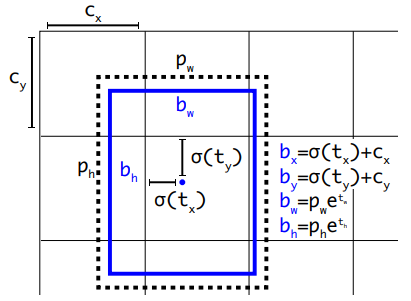

### [Bounding Box Prediction 관련 파라미터 ]

  - $ c_x, c_y$ : grid셀의 **좌측 상단 모서리 좌표(offsets)**
  - $ p_w, p_h$ : 앵커 박스의 너비 및 높이
  - $ t_x, t_y, t_w, t_h$ : YOLO가 예측해야하는 물체의 좌표 값 (Bounding Box)
  - $ b_x, b_y, b_w, b_h$ : 위에서 언급한 값들을 조정하여 실제 GT(Ground Truth, 라벨 값, 정답)와 IOU(Intersection Over Union)를 계산할 최종 bounding box의 offsets값들
    - $b_x, b_y$ : Sigmoid 함수를 통해 $t_x, t_y$ 값을 0~1 사이의 값으로 초기화

### ??? IOU, GT가 뭘까 ???

- IOU (Intersection Over Union)
    - 두 영역의 **교차 영역의 넓이를 합 영엯의 값으로 나눈 값**
    - 객체 검출에서 예측된 경계 상자의 정확도를 평가하는 지표 중 하나로 사용됨.
    - 예측된 경계 상자와 **실제 참값(GT : Ground Truth)** 경계 상자의 IOU를 해당 경계 상자의 ‘정확도’로 간주함
    - 객체 검출 모델의 정확도는 모델을 테스트용 데이터셋에서 실행해본 다음 정밀도-재현율 곡선(precision-recall curve)과 평균 정밀도(average precision)를 구해 수치화할 수 있는데, 이 과정에서 IOU 값이 사용됨.
    

- GT(Ground Truth) : 실제 참값


참조 : https://inspace4u.github.io/dllab/lecture/2017/09/28/IoU.html

- 훈련동안 Sum of Squared Error(오차 제곱합)을 loss 함수로 사용한다.
- YOLOv3은 로지스틱 회귀(or sigmoid function)를 사용하여 각 바운딩 박스에 대한 objectness(객관성) 점수를 예측 -> 바운딩 박스 안에 물체 유무 판단.
- 다른 여러 앵커 박스(Bounding box prioir)보다 실제 물체(GT or Ground Truth Object)와 많이 겹치는 앵커 박스. 즉, IOU가 높은 앵커 박스를 1이라 칭하여 매칭한다. 
- 그 외의 박스(Best는 아니지만, 임계값 이상으로 실제 개체와 겹치는 경우 또는 객체에 앵커 박스가 할당되지 않는 경우 등)에는 예측을 무시한다.
- IOU의 임계값(thershold)은 0.5를 사용

## 2.2. Class prediction 

- 각 Box는 다중 분류(Mulit-label classification)를 사용하여 Bounding Box를 포함할 수 있는 class등을 예측한다
    - 다중 레이블 접근은 데이터를 더 잘 모델링한다.
    
- Class Prediction : Logistic Classifiers(로지스틱 분류기)를 사용함(Softmax보다 더 좋은 성능을 낸다)
    - Logistic Classifiers : Sigmoid, ReLu, tanh 등
    - Softmax를 사용하게 되면, 각 박스들은 정확하게 하나의 클래스를 가정하는데, 이는 종종 옳지 않은 결과를 보인다.
    
- Loss Function : 이중 교자 엔트로피(binary cross-entropy)를 class 예측을 위해 사용한다,
    - 그래서, multi_class classification에서 사용되는 loss 함수인, categorical cross entropy loss를 사용하지 않음.  

## 2.3. Predictions Across Scales
  - YOLOv3에서는 세 가지의 다른 scales에서 boxes를 예측한다.
  - Pyramid Networks를 특징과 유사한 개념을 사용하여, 이 scales에서 특징을 추출한다.
  - 논문에서는 COCO Data sets를 이용하였고 각 scales에서 3개의 박스를 생성하여 진행했다.
    - 모델 형태 : 
      - 텐서 형태 : N × N × [3 ∗ (4 + 1 + 80)] 
        - Bounding Box : 3개
        - Bounding Box Offsets : 4개
        - Objectness prediction : 1개
        - Class predictions : 80개
      - 앵커 박스(Bounding Box Priors)를 결정하기 위해 k-means clustering을 사용
      - 세 가지의 다른 scales를 이용하며, 이에 각 scales에 3개의 박스를 생성하기 때문에, 총 9개의 cluster를 사용한다.
      - COCO Data sets에서 사용한 앵커 Box 형태 :
         - (10×13),(16×30),(33×23),(30×61),(62×45),(59×119),(116 × 90),(156 × 198),(373 × 326)

## 2.4. Feature Extractor 

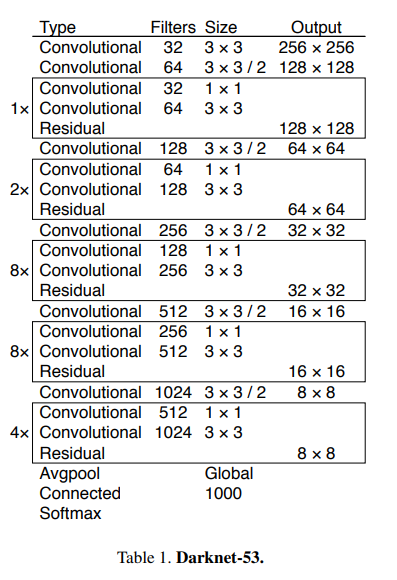